# **Tutorial 3: Reconstructing Past Changes in Terrestrial Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Brodie Pearson

**Content editors:** Dionessa Biton

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

## **Code and Data Sources**

Code for this tutorial is based on an existing notebook from LinkedEarth that provides instruction on [working with LiPD files](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L1_working_with_LiPD.ipynb). 

Data from the following sources are used in this tutorial:

*   Euro2k database: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88
















# **Tutorial 3 Objectives**

In this tutorial, we’ll explore the Euro2K proxy network, which is a subset of PAGES2K, the database we explored in the first tutorial. We will specifically focus on intepretting temperature change over the past 2,000 years as recorded by proxy records from tree rings, speleothems, and lake sediments. To analyze these datasets, we will group them by archive and create time series plots to assess temperature variations.

During this tutorial you will:


*   Plot temperature records based on three different terrestrial proxies
*   Assess similarities and differences between the temperature records






In [ ]:
# # Install libraries
# !pip install pandas
# !pip install numpy
# !pip install LiPD

# !pip install cartopy
# !pip install pyleoclim

In [ ]:
# Import libraries
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import lipd
import os

## Loading terrestrial paleoclimate records

First, we need to download the data. Similar to Tutorial 1, the data is stored as a LiPD file, and we will be using Pyleoclim to format and interpret the data.

In [ ]:
import os, requests, tarfile
folder_name = "Euro2k"
if not os.path.exists(folder_name):
    url = "https://osf.io/7ezp3/download/"
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            print(f"Downloading {folder_name}...")
            with open(folder_name + ".zip", "wb") as fid:
                fid.write(r.content)
            import zipfile
            with zipfile.ZipFile(folder_name + ".zip", 'r') as zip_ref:
                zip_ref.extractall(".")
            os.remove(folder_name + ".zip")
            print(f"Download {folder_name} completed!")

In [ ]:
# The LiPD object can be used to load datasets stored in the LiPD format.
# In this first case study, we will load an entire library of LiPD files:
d_euro = pyleo.Lipd('Euro2k')

In this next cell of code, we will use `Lipd.to_tso` to obtain a list of dictionaries that can be iterated upon. Dictionaries are native to Python and can be easily explored as shown below. The first line of the code creates the list of dictionaries while the for loop goes over each dictionary to lift relevant information that would allow us to identify the relevant dictionary for our work and print it out per index:



In [ ]:
ts_list = d_euro.to_tso()
for idx, item in enumerate(ts_list):
    print(str(idx)+': '+item['dataSetName']+': '+item['paleoData_variableName'])

Once we have our data downloaded and organized, we need to store the data as a `LipdSeriesList`:

In [ ]:
ts_SeriesList = d_euro.to_LipdSeriesList()

In [ ]:
series = pyleo.MultipleSeries(ts_SeriesList)

Next, we can filter all of the data so that we only keep reconstructions from terrestrial archives (tree rings, speleothems and lake sediments).

In [ ]:
def filter_data(dataset, archive_type, variable_name):
    """
    Return a MultipleSeries object with the variable record (variable_name) for a given archive_type.
    """
    # Create a list of dictionary that can be iterated upon using Lipd.to_tso method
    ts_list = dataset.to_tso()
    # Append the correct indices for a given value of archive_type and variable_name
    indices = []
    for idx, item in enumerate(ts_list):
        # Check that it is available to avoid errors on the loop
        if 'archiveType' in item.keys():
            # If it's a archive_type, then proceed to the next step
            if item['archiveType'] == archive_type:
                if item['paleoData_variableName'] == variable_name:
                    indices.append(idx)
    print(indices)
    # Create a list of LipdSeries for the given indices
    ts_list_archive_type = []
    for indice in indices:
        ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))

    return pyleo.MultipleSeries(ts_list_archive_type)

Let's create a new list that only has temperature reconstructions based on proxies from **lake sediments**:

In [ ]:
ms_euro_lake = filter_data(d_euro, 'lake sediment', 'temperature')

Let's create a new list that only has temperature reconstructions based on proxies from **tree rings**:

In [ ]:
ms_euro_tree = filter_data(d_euro, 'tree', 'temperature')

Let's create a new list that only has temperature reconstructions based on proxies from **speleothems**:

In [ ]:
ms_euro_spel = filter_data(d_euro, 'speleothem', 'd18O')

Here is a map of the locaition of the terrestrial proxy records we'll be looking at. Blue dots are lake sediments, green dots are tree rings, and yellow dots are speleothems:


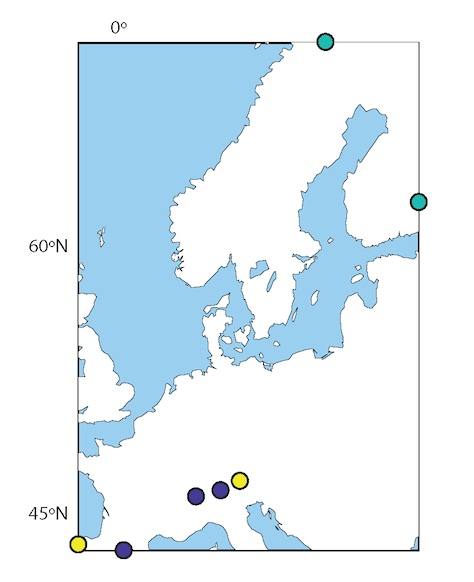

Since we are going to compare temperature datasets based on different terrestrial climate archives (lake sediments, tree rings and speleothems), the quantitative values of the measurements in each record will differ (i.e., the lake sediment and tree ring data are temperature in degrees C, but the speleothem data is oxygen isotopes in per mille). Therefore, to more easily and accurately compare temperature between the records, it's helpful to standardize the data. The .standardize () function removes the estimated mean of the time series and divides by its estimated standard deviation.

In [ ]:
#Standardize the data
spel_stnd = ms_euro_spel.standardize()
lake_stnd = ms_euro_lake.standardize()
tree_stnd = ms_euro_tree.standardize()

Now we can use Pyleoclim functions to create three stacked plots of this data with lake sediment records on top, tree ring reconstructions in the middle and speleothem records on the bottom:

In [ ]:
lake_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="year", title='Lake Cores',color='blue')
tree_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="year", title='Tree Rings', color='green')
spel_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="year", title='Speleothems',color='yellow')

Using the plots we just made (and recalling that all of these records are from Europe), let's make some inferences about the temperature data over the past 2,000 years:


*   Do the three proxy types record the same patterns? 
*   Do the temperature records based on a single proxy type record similar patterns?
*   What is the long term temperature trend during this period of time?
*   What might be causing the more frequent variations in temperature?


If you'd like to further explore these datasets, here are some ideas for additional analyses:
*   Recall during W1D1 when we learned about calculating and plotting a running mean of climate time series data. Try plotting a running average of these time series to assess long-term temperature change over the past 2,000 years.
*   Try plotting these temperature records zoomed into just the past 200 years to assess more recent temperature change.



